# Fast Sign Adversary Generation Example

This notebook demos find adversary example by using symbolic API and integration with Numpy
Reference: 

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." arXiv preprint arXiv:1412.6572 (2014).

In [1]:
%matplotlib inline
import mxnet as mx
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from data import mnist_iterator

Build Network

note: in this network, we will calculate softmax, gradient in numpy

In [2]:
dev = mx.gpu()
batch_size = 100
train_iter, val_iter = mnist_iterator(batch_size=batch_size, input_shape = (1,28,28))

In [3]:
# input
data = mx.symbol.Variable('data')
# first conv
conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max",
                          kernel=(2,2), stride=(2,2))
# second conv
conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max",
                          kernel=(2,2), stride=(2,2))
# first fullc
flatten = mx.symbol.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=10)

In [4]:
def Softmax(theta):
    max_val = np.max(theta, axis=1, keepdims=True)
    tmp = theta - max_val
    exp = np.exp(tmp)
    norm = np.sum(exp, axis=1, keepdims=True)
    return exp / norm

In [5]:
def LogLossGrad(alpha, label):
    grad = np.copy(alpha)
    for i in range(alpha.shape[0]):
        grad[i, label[i]] -= 1.
    return grad

Prepare useful data for the network

In [6]:
data_shape = (batch_size, 1, 28, 28)
arg_names = fc2.list_arguments() # 'data' 
arg_shapes, output_shapes, aux_shapes = fc2.infer_shape(data=data_shape)

arg_arrays = [mx.nd.zeros(shape, ctx=dev) for shape in arg_shapes]
grad_arrays = [mx.nd.zeros(shape, ctx=dev) for shape in arg_shapes]
reqs = ["write" for name in arg_names]

model = fc2.bind(ctx=dev, args=arg_arrays, args_grad = grad_arrays, grad_req=reqs)
arg_map = dict(zip(arg_names, arg_arrays))
grad_map = dict(zip(arg_names, grad_arrays))
data_grad = grad_map["data"]
out_grad = mx.nd.zeros(model.outputs[0].shape, ctx=dev)

Init weight 

In [7]:
for name in arg_names:
    if "weight" in name:
        arr = arg_map[name]
        arr[:] = mx.rnd.uniform(-0.07, 0.07, arr.shape)

In [8]:
def SGD(weight, grad, lr=0.1, grad_norm=batch_size):
    weight[:] -= lr * grad / batch_size

def CalAcc(pred_prob, label):
    pred = np.argmax(pred_prob, axis=1)
    return np.sum(pred == label) * 1.0

def CalLoss(pred_prob, label):
    loss = 0.
    for i in range(pred_prob.shape[0]):
        loss += -np.log(max(pred_prob[i, label[i]], 1e-10))
    return loss

Train a network

In [9]:
num_round = 4
train_acc = 0.
nbatch = 0
for i in range(num_round):
    train_loss = 0.
    train_acc = 0.
    nbatch = 0
    train_iter.reset()
    for data, label in train_iter:
        arg_map["data"][:] = data
        model.forward(is_train=True)
        theta = model.outputs[0].asnumpy()
        alpha = Softmax(theta)
        train_acc += CalAcc(alpha, label.asnumpy()) / batch_size
        train_loss += CalLoss(alpha, label.asnumpy()) / batch_size
        losGrad_theta = LogLossGrad(alpha, label.asnumpy())
        out_grad[:] = losGrad_theta
        model.backward([out_grad])
        # data_grad[:] = grad_map["data"]
        for name in arg_names:
            if name != "data":
                SGD(arg_map[name], grad_map[name])
        
        nbatch += 1
    #print(np.linalg.norm(data_grad.asnumpy(), 2))
    train_acc /= nbatch
    train_loss /= nbatch
    print("Train Accuracy: %.2f\t Train Loss: %.5f" % (train_acc, train_loss))

Train Accuracy: 0.92	 Train Loss: 0.28077
Train Accuracy: 0.97	 Train Loss: 0.08434
Train Accuracy: 0.98	 Train Loss: 0.05849
Train Accuracy: 0.99	 Train Loss: 0.04577


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Get pertubation by using fast sign method, check validation change

In [10]:
val_iter.reset()
data, label = val_iter.next()
arg_map["data"][:] = data
model.forward(is_train=True)
theta = model.outputs[0].asnumpy()
alpha = Softmax(theta)
print("Val Batch Accuracy: ", CalAcc(alpha, label.asnumpy()) / batch_size)
#########
grad = LogLossGrad(alpha, label.asnumpy())
out_grad[:] = grad
model.backward([out_grad])
noise = np.sign(data_grad.asnumpy())
arg_map["data"][:] = data.asnumpy() + 0.15 * noise
model.forward(is_train=True)
raw_output = model.outputs[0].asnumpy()
pred = Softmax(raw_output)
print("Val Batch Accuracy after pertubation: ", CalAcc(pred, label.asnumpy()) / batch_size)

Val Batch Accuracy:  1.0
Val Batch Accuracy after pertubation:  0.04


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Visualize example after pertubation

true: 9
pred: 8


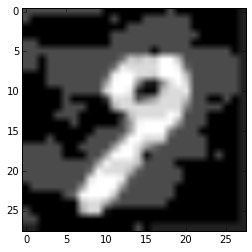

In [11]:
import random as rnd
idx = rnd.randint(0, 99)
images = data.asnumpy()  + 0.15 * noise
plt.imshow(images[idx, :].reshape(28,28), cmap=cm.Greys_r)
print("true: %d" % label.asnumpy()[idx])
print("pred: %d" % np.argmax(pred, axis=1)[idx])